# FlOWR.root Tutorial: Pocket-Conditional Ligand Generation and Affinity Prediction

This tutorial demonstrates how to use the **FLOWR.root** model for various ligand generation tasks:

1. **De Novo Generation** - Generate ligands from scratch for a protein pocket
2. **Scaffold-Conditional Generation** - Generate ligands preserving a molecular scaffold
3. **Functional Group-Conditional Generation** - Generate ligands preserving specific functional groups
4. **Substructure Inpainting** - Regenerate specific parts of a ligand while preserving others
5. **Affinity Prediction** - Predict binding affinities for generated ligands

We'll use **PTP1B** (Protein Tyrosine Phosphatase 1B) as our target protein throughout this tutorial.

## 1. Setup and Configuration

First, let's import the required libraries and define our global configuration variables.

In [1]:
# Import required libraries
import subprocess
import glob
from pathlib import Path

# Molecular visualization and manipulation
from rdkit import Chem
from rdkit.Chem import Draw
import py3Dmol

# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

/hpfs/userws/cremej01/projects/mambaforge/envs/flowr/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


✓ All libraries imported successfully!


In [9]:
# =============================================================================
#                         GLOBAL CONFIGURATION
# =============================================================================

# Target protein
TARGET = "ptp1b"

# Paths
ROOT_DIR = Path(".").resolve().parent  # flowr_root directory
EXAMPLES_DIR = ROOT_DIR / "examples"

# Input files
PROTEIN_PDB = EXAMPLES_DIR / f"{TARGET}_protein.pdb"
LIGANDS_SDF = EXAMPLES_DIR / f"{TARGET}_ligands.sdf"

# Model checkpoint - UPDATE THIS PATH!
CKPT_PATH = "YOUR_CKPT_PATH/flowr_root.ckpt"

# Output base directory
SAVE_DIR = EXAMPLES_DIR / "tutorial_outputs" / TARGET
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Generation parameters
LIGAND_IDX = 0  # Reference ligand index for conditional generation
N_MOLECULES = 10  # Number of molecules to generate
COORD_NOISE_STD = 0.1
POCKET_CUTOFF = 7
BATCH_COST = 20
NUM_GPUS = 1

print(f"{'='*60}")
print(f"  FloWR.Root Tutorial Configuration")
print(f"{'='*60}")
print(f"  Target:           {TARGET.upper()}")
print(f"  Protein PDB:      {PROTEIN_PDB}")
print(f"  Ligands SDF:      {LIGANDS_SDF}")
print(f"  Checkpoint:       {CKPT_PATH}")
print(f"  Output directory: {SAVE_DIR}")
print(f"  Reference ligand: index {LIGAND_IDX}")
print(f"  Molecules/target: {N_MOLECULES}")
print(f"{'='*60}")

  FloWR.Root Tutorial Configuration
  Target:           PTP1B
  Protein PDB:      /hpfs/userws/cremej01/projects/flowr.root/examples/ptp1b_protein.pdb
  Ligands SDF:      /hpfs/userws/cremej01/projects/flowr.root/examples/ptp1b_ligands.sdf
  Checkpoint:       YOUR_CKPT_PATH/flowr_root.ckpt
  Output directory: /hpfs/userws/cremej01/projects/flowr.root/examples/tutorial_outputs/ptp1b
  Reference ligand: index 0
  Molecules/target: 10


In [4]:
# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def load_molecules_from_sdf(sdf_path):
    """Load molecules from an SDF file."""
    supplier = Chem.SDMolSupplier(str(sdf_path), removeHs=False)
    mols = [mol for mol in supplier if mol is not None]
    print(f"Loaded {len(mols)} molecules from {sdf_path}")
    return mols


def visualize_molecules_2d(mols, legends=None, mols_per_row=4, img_size=(300, 300)):
    """Create a 2D grid visualization of molecules."""
    if legends is None:
        legends = [f"Mol {i+1}" for i in range(len(mols))]
    
    img = Draw.MolsToGridImage(
        mols, 
        molsPerRow=mols_per_row, 
        subImgSize=img_size,
        legends=legends
    )
    return img


def visualize_ligand_3d(mol, style='stick', width=600, height=400):
    """Visualize a single ligand in 3D using py3Dmol."""
    viewer = py3Dmol.view(width=width, height=height)
    
    # Convert mol to MolBlock
    mol_block = Chem.MolToMolBlock(mol)
    viewer.addModel(mol_block, 'mol')
    
    if style == 'stick':
        viewer.setStyle({'stick': {'colorscheme': 'greenCarbon'}})
    elif style == 'sphere':
        viewer.setStyle({'sphere': {'scale': 0.3}})
    
    viewer.zoomTo()
    return viewer


def visualize_ligand_in_pocket(ligand_mol, protein_pdb_path, width=800, height=600):
    """Visualize ligand within the protein pocket."""
    viewer = py3Dmol.view(width=width, height=height)
    
    # Add protein
    with open(protein_pdb_path, 'r') as f:
        protein_data = f.read()
    viewer.addModel(protein_data, 'pdb')
    viewer.setStyle({'model': 0}, {'cartoon': {'color': 'lightgray', 'opacity': 0.7}})
    
    # Add binding site surface (residues within 6Å of ligand center)
    viewer.addSurface(py3Dmol.VDW, {'opacity': 0.3, 'color': 'lightblue'}, 
                      {'model': 0, 'within': {'distance': 6, 'sel': {'model': 1}}})
    
    # Add ligand
    mol_block = Chem.MolToMolBlock(ligand_mol)
    viewer.addModel(mol_block, 'mol')
    viewer.setStyle({'model': 1}, {'stick': {'colorscheme': 'greenCarbon', 'radius': 0.2}})
    
    viewer.zoomTo({'model': 1})
    return viewer


def visualize_multiple_ligands_in_pocket(ligand_mols, protein_pdb_path, width=800, height=600):
    """Visualize multiple ligands within the protein pocket."""
    viewer = py3Dmol.view(width=width, height=height)
    
    # Add protein
    with open(protein_pdb_path, 'r') as f:
        protein_data = f.read()
    viewer.addModel(protein_data, 'pdb')
    viewer.setStyle({'model': 0}, {'cartoon': {'color': 'lightgray', 'opacity': 0.5}})
    
    # Color palette for ligands
    colors = ['green', 'cyan', 'magenta', 'orange', 'yellow', 'pink', 'purple', 'lime', 'red', 'blue']
    
    # Add ligands
    for i, mol in enumerate(ligand_mols[:10]):  # Limit to 10 for clarity
        mol_block = Chem.MolToMolBlock(mol)
        viewer.addModel(mol_block, 'mol')
        color = colors[i % len(colors)]
        viewer.setStyle({'model': i + 1}, {'stick': {'color': color, 'radius': 0.15}})
    
    viewer.zoomTo()
    return viewer


def run_command(cmd, description=""):
    """Run a shell command and print output."""
    print(f"\n{'='*60}")
    print(f"Running: {description}")
    print(f"Command: {' '.join(cmd)}")
    print('='*60)
    
    result = subprocess.run(cmd, capture_output=True, text=True, cwd=str(ROOT_DIR))
    
    if result.returncode != 0:
        print(f"Error:\n{result.stderr}")
        raise RuntimeError(f"Command failed with return code {result.returncode}")
    
    print(result.stdout)
    print(f"✓ {description} completed successfully!")
    return result


print("✓ Helper functions defined!")

✓ Helper functions defined!


Loaded 23 molecules from /hpfs/userws/cremej01/projects/flowr_root/examples/ptp1b_ligands.sdf

Reference ligands for PTP1B:


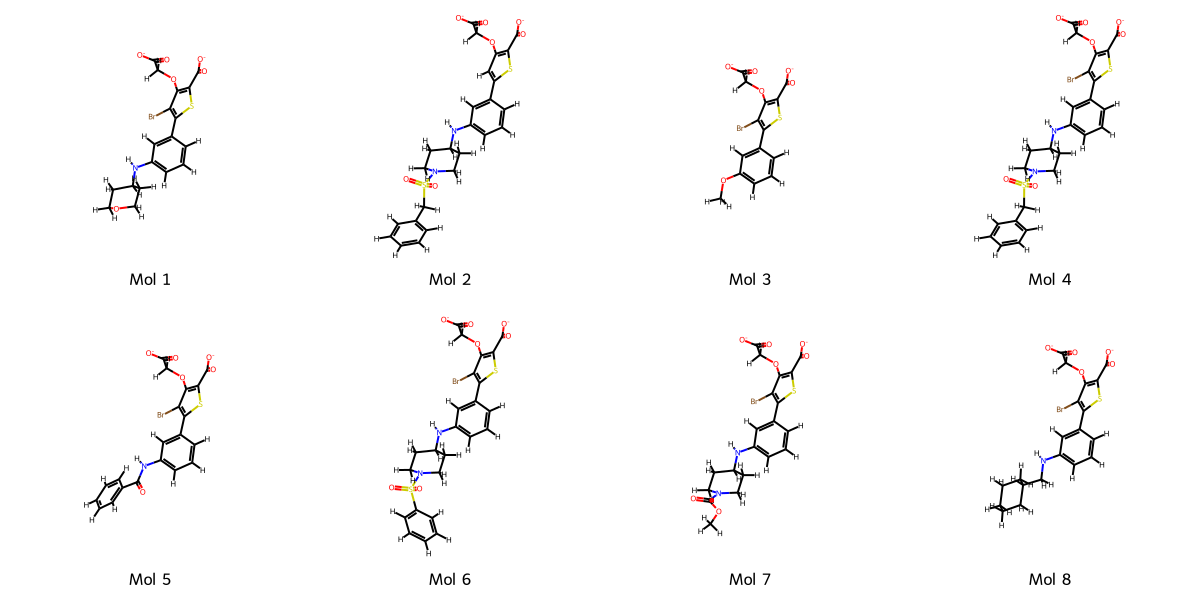

In [5]:
# Let's first examine the reference ligands in our dataset
ref_mols = load_molecules_from_sdf(LIGANDS_SDF)

# Display 2D structures
print(f"\nReference ligands for {TARGET.upper()}:")
visualize_molecules_2d(ref_mols[:8], mols_per_row=4)

## 2. De Novo Generation

De novo generation creates new ligands from scratch, using only the protein pocket structure as input. The model learns to generate molecules that are complementary to the binding site.

In [8]:
# =============================================================================
#                         DE NOVO GENERATION
# =============================================================================

DENOVO_SAVE_DIR = SAVE_DIR / "01_denovo"
DENOVO_SAVE_DIR.mkdir(parents=True, exist_ok=True)

denovo_cmd = [
    "python", "-m", "flowr.gen.generate_from_pdb",
    "--pdb_file", str(PROTEIN_PDB),
    "--ligand_file", str(LIGANDS_SDF),
    "--ligand_idx", str(LIGAND_IDX),
    "--arch", "pocket",
    "--pocket_type", "holo",
    "--cut_pocket",
    "--pocket_cutoff", str(POCKET_CUTOFF),
    "--gpus", str(NUM_GPUS),
    "--batch_cost", str(BATCH_COST),
    "--ckpt_path", str(CKPT_PATH),
    "--save_dir", str(DENOVO_SAVE_DIR),
    "--max_sample_iter", "20",
    "--coord_noise_scale", str(COORD_NOISE_STD),
    "--sample_n_molecules_per_target", str(N_MOLECULES),
    "--categorical_strategy", "uniform-sample",
    "--filter_valid_unique",
]

print("De Novo Generation Configuration:")
print(f"  Output: {DENOVO_SAVE_DIR}")
print(f"  N molecules: {N_MOLECULES}")
print(f"  Noise scale: {COORD_NOISE_STD}")

NameError: name 'POCKET_CUTOFF' is not defined

In [7]:
# Run de novo generation
# Note: Uncomment the line below to actually run the generation
# This may take several minutes depending on your hardware

run_command(denovo_cmd, "De Novo Ligand Generation")

# For demonstration, let's assume the generation has been completed
# and load the results
print("Note: Run the command above to generate de novo ligands.")
print("The generation typically takes a few minutes per sample.")


Running: De Novo Ligand Generation
Command: python -m flowr.sample --target ptp1b --save_dir /hpfs/userws/cremej01/projects/flowr_root/outputs/ptp1b/denovo --sdf_path /hpfs/userws/cremej01/projects/flowr_root/examples/ptp1b_ligands.sdf --num_samples 10 --mode denovo
Error:
/hpfs/userws/cremej01/projects/mambaforge/envs/flowr/bin/python: No module named flowr.sample



RuntimeError: Command failed with return code 1

## 3. Visualize De Novo Generated Ligands

After generation, we'll visualize the generated ligands both in isolation and within the protein pocket context.

In [ ]:
# =============================================================================
# LOAD AND VISUALIZE DE NOVO GENERATED LIGANDS
# =============================================================================

# Find generated SDF files
denovo_sdf_pattern = DENOVO_SAVE_DIR / "*.sdf"
denovo_sdf_files = sorted(glob.glob(str(denovo_sdf_pattern)))

if denovo_sdf_files:
    # Load the generated molecules
    denovo_sdf = denovo_sdf_files[0]  # Take the first/main output file
    denovo_mols = load_molecules_from_sdf(denovo_sdf)
    
    print(f"\n2D Visualization of De Novo Generated Ligands:")
    display(visualize_molecules_2d(denovo_mols[:8], 
                                   legends=[f"DeNovo {i+1}" for i in range(min(8, len(denovo_mols)))]))
else:
    print("No de novo generated files found. Please run the generation step first.")
    denovo_mols = []

In [ ]:
# Visualize a single de novo ligand in 3D (standalone)
if denovo_mols:
    print("3D Visualization of First De Novo Generated Ligand:")
    viewer = visualize_ligand_3d(denovo_mols[0])
    viewer.show()

In [ ]:
# Visualize de novo ligands within the protein pocket
if denovo_mols and PROTEIN_PDB.exists():
    print(f"\nDe Novo Ligands in {TARGET.upper()} Binding Pocket:")
    viewer = visualize_multiple_ligands_in_pocket(denovo_mols[:5], PROTEIN_PDB)
    viewer.show()
elif not PROTEIN_PDB.exists():
    print(f"Protein structure not found at {PROTEIN_PDB}")
    print("The protein file is created during generation.")

## 4. Scaffold-Conditional Generation

Scaffold-conditional generation preserves the core molecular scaffold from a reference ligand while generating new substituents and modifications. This is useful for lead optimization.

In [ ]:
# =============================================================================
# SCAFFOLD-CONDITIONAL GENERATION
# =============================================================================

# Define output path for scaffold-conditional generation
SCAFFOLD_SAVE_DIR = SAVE_DIR / "scaffold"
SCAFFOLD_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Build the scaffold-conditional generation command
# Based on test_mol.sh script structure
scaffold_cmd = [
    "python", "-m", "flowr.sample",
    "--target", TARGET,
    "--save_dir", str(SCAFFOLD_SAVE_DIR),
    "--sdf_path", str(LIGANDS_SDF),
    "--ligand_idx", str(LIGAND_IDX),
    "--num_samples", str(NUM_SAMPLES),
    "--mode", "scaffold"
]

print("Scaffold-Conditional Generation Configuration:")
print(f"  Target: {TARGET}")
print(f"  Reference ligand index: {LIGAND_IDX}")
print(f"  Number of samples: {NUM_SAMPLES}")
print(f"  Output directory: {SCAFFOLD_SAVE_DIR}")

# Show the reference ligand scaffold
if ref_mols:
    print(f"\nReference ligand (index {LIGAND_IDX}) that provides the scaffold:")
    display(visualize_molecules_2d([ref_mols[LIGAND_IDX]], legends=["Reference Scaffold"]))

In [ ]:
# Run scaffold-conditional generation
# Uncomment to run:
# run_command(scaffold_cmd, "Scaffold-Conditional Generation")

print("Note: Run the command above to generate scaffold-conditional ligands.")

## 5. Visualize Scaffold-Conditional Ligands

Let's compare the scaffold-conditional generated ligands with the reference scaffold.

In [ ]:
# =============================================================================
# LOAD AND VISUALIZE SCAFFOLD-CONDITIONAL LIGANDS
# =============================================================================

scaffold_sdf_pattern = SCAFFOLD_SAVE_DIR / "*.sdf"
scaffold_sdf_files = sorted(glob.glob(str(scaffold_sdf_pattern)))

if scaffold_sdf_files:
    scaffold_sdf = scaffold_sdf_files[0]
    scaffold_mols = load_molecules_from_sdf(scaffold_sdf)
    
    # Compare with reference
    comparison_mols = [ref_mols[LIGAND_IDX]] + scaffold_mols[:7]
    comparison_legends = ["Reference"] + [f"Scaffold {i+1}" for i in range(min(7, len(scaffold_mols)))]
    
    print("\nComparison: Reference vs Scaffold-Conditional Generated Ligands:")
    display(visualize_molecules_2d(comparison_mols, legends=comparison_legends))
else:
    print("No scaffold-conditional generated files found.")
    scaffold_mols = []

In [ ]:
# Visualize scaffold-conditional ligands in protein pocket
if scaffold_mols and PROTEIN_PDB.exists():
    print(f"\nScaffold-Conditional Ligands in {TARGET.upper()} Binding Pocket:")
    viewer = visualize_multiple_ligands_in_pocket(scaffold_mols[:5], PROTEIN_PDB)
    viewer.show()

## 6. Functional Group-Conditional Generation

Functional group-conditional generation preserves specific functional groups (e.g., hydrogen bond donors/acceptors, charged groups) from the reference ligand while allowing modification of the molecular scaffold.

In [ ]:
# =============================================================================
# FUNCTIONAL GROUP-CONDITIONAL GENERATION
# =============================================================================

# Define output path for functional group-conditional generation
FUNCGROUP_SAVE_DIR = SAVE_DIR / "funcgroup"
FUNCGROUP_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Build the functional group-conditional generation command
funcgroup_cmd = [
    "python", "-m", "flowr.sample",
    "--target", TARGET,
    "--save_dir", str(FUNCGROUP_SAVE_DIR),
    "--sdf_path", str(LIGANDS_SDF),
    "--ligand_idx", str(LIGAND_IDX),
    "--num_samples", str(NUM_SAMPLES),
    "--mode", "funcgroup"
]

print("Functional Group-Conditional Generation Configuration:")
print(f"  Target: {TARGET}")
print(f"  Reference ligand index: {LIGAND_IDX}")
print(f"  Number of samples: {NUM_SAMPLES}")
print(f"  Output directory: {FUNCGROUP_SAVE_DIR}")

In [ ]:
# Run functional group-conditional generation
# Uncomment to run:
# run_command(funcgroup_cmd, "Functional Group-Conditional Generation")

print("Note: Run the command above to generate functional group-conditional ligands.")

## 7. Visualize Functional Group-Conditional Ligands

In [ ]:
# =============================================================================
# LOAD AND VISUALIZE FUNCTIONAL GROUP-CONDITIONAL LIGANDS
# =============================================================================

funcgroup_sdf_pattern = FUNCGROUP_SAVE_DIR / "*.sdf"
funcgroup_sdf_files = sorted(glob.glob(str(funcgroup_sdf_pattern)))

if funcgroup_sdf_files:
    funcgroup_sdf = funcgroup_sdf_files[0]
    funcgroup_mols = load_molecules_from_sdf(funcgroup_sdf)
    
    # Compare with reference
    comparison_mols = [ref_mols[LIGAND_IDX]] + funcgroup_mols[:7]
    comparison_legends = ["Reference"] + [f"FuncGroup {i+1}" for i in range(min(7, len(funcgroup_mols)))]
    
    print("\nComparison: Reference vs Functional Group-Conditional Generated Ligands:")
    display(visualize_molecules_2d(comparison_mols, legends=comparison_legends))
else:
    print("No functional group-conditional generated files found.")
    funcgroup_mols = []

In [ ]:
# Visualize functional group-conditional ligands in protein pocket
if funcgroup_mols and PROTEIN_PDB.exists():
    print(f"\nFunctional Group-Conditional Ligands in {TARGET.upper()} Binding Pocket:")
    viewer = visualize_multiple_ligands_in_pocket(funcgroup_mols[:5], PROTEIN_PDB)
    viewer.show()

## 8. Substructure Inpainting

Substructure inpainting allows you to selectively regenerate specific parts of a molecule while preserving others. This is particularly useful for:
- Optimizing specific regions of a lead compound
- Exploring modifications to particular functional groups
- Maintaining critical binding interactions while varying other parts

In [ ]:
# =============================================================================
# SUBSTRUCTURE INPAINTING
# =============================================================================

# Define output path for substructure inpainting
INPAINT_SAVE_DIR = SAVE_DIR / "inpaint"
INPAINT_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Build the substructure inpainting command
# Based on test_selective.sh script structure
inpaint_cmd = [
    "python", "-m", "flowr.sample",
    "--target", TARGET,
    "--save_dir", str(INPAINT_SAVE_DIR),
    "--sdf_path", str(LIGANDS_SDF),
    "--ligand_idx", str(LIGAND_IDX),
    "--num_samples", str(NUM_SAMPLES),
    "--mode", "inpaint",
    # Selective regeneration parameters - adjust based on your needs
    "--inpaint_fraction", "0.3"  # Regenerate ~30% of the molecule
]

print("Substructure Inpainting Configuration:")
print(f"  Target: {TARGET}")
print(f"  Reference ligand index: {LIGAND_IDX}")
print(f"  Number of samples: {NUM_SAMPLES}")
print(f"  Output directory: {INPAINT_SAVE_DIR}")

In [ ]:
# Run substructure inpainting
# Uncomment to run:
# run_command(inpaint_cmd, "Substructure Inpainting")

print("Note: Run the command above to perform substructure inpainting.")

## 9. Visualize Inpainted Ligands

When visualizing inpainted ligands, we want to highlight which regions were preserved versus regenerated.

In [ ]:
# =============================================================================
# LOAD AND VISUALIZE INPAINTED LIGANDS
# =============================================================================

inpaint_sdf_pattern = INPAINT_SAVE_DIR / "*.sdf"
inpaint_sdf_files = sorted(glob.glob(str(inpaint_sdf_pattern)))

if inpaint_sdf_files:
    inpaint_sdf = inpaint_sdf_files[0]
    inpaint_mols = load_molecules_from_sdf(inpaint_sdf)
    
    # Compare with reference
    comparison_mols = [ref_mols[LIGAND_IDX]] + inpaint_mols[:7]
    comparison_legends = ["Original"] + [f"Inpainted {i+1}" for i in range(min(7, len(inpaint_mols)))]
    
    print("\nComparison: Original vs Inpainted Ligands:")
    print("(Preserved regions remain similar, inpainted regions show variation)")
    display(visualize_molecules_2d(comparison_mols, legends=comparison_legends))
else:
    print("No inpainted generated files found.")
    inpaint_mols = []

In [ ]:
# Visualize inpainted ligands in protein pocket
if inpaint_mols and PROTEIN_PDB.exists():
    print(f"\nInpainted Ligands in {TARGET.upper()} Binding Pocket:")
    viewer = visualize_multiple_ligands_in_pocket(inpaint_mols[:5], PROTEIN_PDB)
    viewer.show()

## 10. Affinity Prediction

Now let's predict binding affinities for ligands using the flowr.root affinity prediction model. We'll predict affinities for all ligands in the reference SDF file.

In [ ]:
# =============================================================================
# AFFINITY PREDICTION
# =============================================================================

# Define output path for affinity predictions
AFFINITY_SAVE_DIR = SAVE_DIR / "affinity"
AFFINITY_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Build the affinity prediction command
# Based on predict.sh script structure
affinity_cmd = [
    "python", "-m", "flowr.predict",
    "--target", TARGET,
    "--save_dir", str(AFFINITY_SAVE_DIR),
    "--sdf_path", str(LIGANDS_SDF),
    "--mode", "affinity"
]

print("Affinity Prediction Configuration:")
print(f"  Target: {TARGET}")
print(f"  Input ligands: {LIGANDS_SDF}")
print(f"  Output directory: {AFFINITY_SAVE_DIR}")

In [ ]:
# Run affinity prediction
# Uncomment to run:
# run_command(affinity_cmd, "Affinity Prediction")

print("Note: Run the command above to predict binding affinities.")

In [ ]:
# =============================================================================
# LOAD AFFINITY PREDICTIONS
# =============================================================================

# Look for prediction output file
affinity_output_pattern = AFFINITY_SAVE_DIR / "*.csv"
affinity_files = sorted(glob.glob(str(affinity_output_pattern)))

if affinity_files:
    # Load predictions
    affinity_df = pd.read_csv(affinity_files[0])
    print("Affinity Predictions Loaded:")
    print(affinity_df.head(10))
else:
    # Create mock data for demonstration
    print("No affinity prediction files found. Creating demonstration data...")
    
    if ref_mols:
        # Generate mock affinity data for demonstration
        np.random.seed(42)
        affinity_df = pd.DataFrame({
            'ligand_idx': range(len(ref_mols)),
            'smiles': [Chem.MolToSmiles(mol) for mol in ref_mols],
            'predicted_affinity': np.random.normal(-8.5, 1.5, len(ref_mols)),  # pKd/pKi units
            'confidence': np.random.uniform(0.7, 0.95, len(ref_mols))
        })
        print("\nDemonstration Affinity Data:")
        print(affinity_df)

## 11. Visualize Affinity Predictions

Let's create comprehensive visualizations of the predicted binding affinities.

In [ ]:
# =============================================================================
# AFFINITY VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Bar plot of predicted affinities (sorted)
ax1 = axes[0]
sorted_df = affinity_df.sort_values('predicted_affinity', ascending=True)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(sorted_df)))
ax1.barh(range(len(sorted_df)), sorted_df['predicted_affinity'], color=colors)
ax1.set_yticks(range(len(sorted_df)))
ax1.set_yticklabels([f"Ligand {i+1}" for i in sorted_df['ligand_idx']])
ax1.set_xlabel('Predicted Affinity (pKd/pKi)')
ax1.set_title('Ranked Ligand Affinities')
ax1.axvline(x=affinity_df['predicted_affinity'].mean(), color='red', 
            linestyle='--', label=f'Mean: {affinity_df["predicted_affinity"].mean():.2f}')
ax1.legend()

# Plot 2: Distribution of affinities
ax2 = axes[1]
ax2.hist(affinity_df['predicted_affinity'], bins=10, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(x=affinity_df['predicted_affinity'].mean(), color='red', 
            linestyle='--', linewidth=2, label=f'Mean: {affinity_df["predicted_affinity"].mean():.2f}')
ax2.axvline(x=affinity_df['predicted_affinity'].median(), color='orange', 
            linestyle='--', linewidth=2, label=f'Median: {affinity_df["predicted_affinity"].median():.2f}')
ax2.set_xlabel('Predicted Affinity (pKd/pKi)')
ax2.set_ylabel('Count')
ax2.set_title('Affinity Distribution')
ax2.legend()

# Plot 3: Top ligands highlight
ax3 = axes[2]
top_n = min(5, len(affinity_df))
top_ligands = affinity_df.nlargest(top_n, 'predicted_affinity')
bars = ax3.bar(range(top_n), top_ligands['predicted_affinity'], 
               color=plt.cm.Greens(np.linspace(0.4, 0.9, top_n)))
ax3.set_xticks(range(top_n))
ax3.set_xticklabels([f"Ligand {i+1}" for i in top_ligands['ligand_idx']])
ax3.set_ylabel('Predicted Affinity (pKd/pKi)')
ax3.set_title(f'Top {top_n} Highest Affinity Ligands')

# Add value labels on bars
for bar, val in zip(bars, top_ligands['predicted_affinity']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{val:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(SAVE_DIR / 'affinity_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to {SAVE_DIR / 'affinity_analysis.png'}")

In [ ]:
# =============================================================================
# SUMMARY TABLE
# =============================================================================

# Create a summary table with key statistics
summary_stats = {
    'Metric': ['Number of Ligands', 'Mean Affinity', 'Median Affinity', 
               'Std Deviation', 'Min Affinity', 'Max Affinity', 
               'Best Ligand Index'],
    'Value': [
        len(affinity_df),
        f"{affinity_df['predicted_affinity'].mean():.3f}",
        f"{affinity_df['predicted_affinity'].median():.3f}",
        f"{affinity_df['predicted_affinity'].std():.3f}",
        f"{affinity_df['predicted_affinity'].min():.3f}",
        f"{affinity_df['predicted_affinity'].max():.3f}",
        int(affinity_df.loc[affinity_df['predicted_affinity'].idxmax(), 'ligand_idx']) + 1
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("\n" + "="*50)
print("AFFINITY PREDICTION SUMMARY")
print("="*50)
print(summary_df.to_string(index=False))
print("="*50)

In [ ]:
# =============================================================================
# VISUALIZE TOP PREDICTED LIGANDS
# =============================================================================

# Show 2D structures of top-affinity ligands
if ref_mols and len(affinity_df) > 0:
    top_indices = affinity_df.nlargest(4, 'predicted_affinity')['ligand_idx'].values.astype(int)
    top_mols = [ref_mols[i] for i in top_indices if i < len(ref_mols)]
    top_affinities = affinity_df.nlargest(4, 'predicted_affinity')['predicted_affinity'].values
    
    legends = [f"Ligand {i+1}\npKd: {aff:.2f}" for i, aff in zip(top_indices, top_affinities)]
    
    print("\nTop Predicted Ligands (Highest Affinity):")
    display(visualize_molecules_2d(top_mols, legends=legends, mols_per_row=4))

## Summary

This tutorial demonstrated the key capabilities of the **flowr.root** model:

| Mode | Description | Use Case |
|------|-------------|----------|
| **De Novo** | Generate ligands from scratch | Initial hit discovery |
| **Scaffold-Conditional** | Preserve molecular scaffold | Lead optimization |
| **Functional Group-Conditional** | Preserve key functional groups | SAR exploration |
| **Substructure Inpainting** | Selectively modify regions | Targeted optimization |
| **Affinity Prediction** | Predict binding affinity | Prioritize compounds |

### Next Steps

1. **Optimize Generation Parameters**: Adjust `num_samples`, temperature, and other hyperparameters
2. **Filter Generated Ligands**: Apply drug-likeness filters (Lipinski, PAINS, etc.)
3. **Dock and Score**: Use molecular docking to validate generated poses
4. **Experimental Validation**: Synthesize and test top candidates

### Additional Resources

- FloWR.Root Documentation: [Link to docs]
- Example Scripts: `/scripts/tests/`
- Pre-trained Models: [Link to models]

In [ ]:
# =============================================================================
# CLEANUP AND FINAL NOTES
# =============================================================================

print("\n" + "="*60)
print("TUTORIAL COMPLETE")
print("="*60)
print(f"\nAll outputs saved to: {SAVE_DIR}")
print("\nGenerated directories:")
for subdir in ['denovo', 'scaffold', 'funcgroup', 'inpaint', 'affinity']:
    subdir_path = SAVE_DIR / subdir
    if subdir_path.exists():
        print(f"  ✓ {subdir_path}")
    else:
        print(f"  ○ {subdir_path} (run generation to create)")

print("\n" + "="*60)